**2.1 Building the circuit to prepare the Bell state**

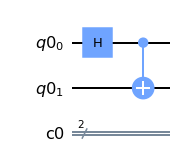

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)

# Applying Hadamard to first qubit
qc.h(q[0])
# Applying CNOT gate where first qubit is control bit, and second qubit is target bit
qc.cx(q[0], q[1])

qc.draw(output='mpl')

In [2]:
# Verifying that bell state has been obtained
qc.measure(q,c)
job = execute(qc,Aer.get_backend('qasm_simulator'),shots=1000)
counts = job.result().get_counts(qc)
print(counts)

{'00': 497, '11': 503}


**2.2  Adding Error Gate with probability p=0.4, in this case we consider the error gate as X-gate, causing the bit flip error**

In [3]:
from random import randrange
# function to introduce error with a probability p
def chance(prob):
    '''
    params:
        prob(float): value of probability
        
    returns:
        cause(bool): 1 or 0
    '''
    limiting_number = int(100 * prob )
    random_number = randrange(100)
    return random_number < limiting_number
    

X Error gate acts on 1 qubit


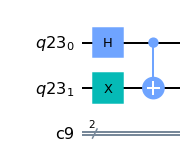

In [15]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)

qc.h(q[0])

# Applying error gate to individual bits
# here for each bit
# - probability of  X-gate acting on it is 0.2 = (0.4 * 0.5)
# - probability of Z-gate acting on it is 0.2 = (0.4 * 0.5)
for i in [0,1]:
    if chance(0.4):
        if randrange(2) == 0:
            qc.x(q[i])
            print('X Error gate acts on {} qubit'.format(i))
        else:
            qc.z(q[i])
            print('Z Error gate acts on {} qubit'.format(i))



qc.cx(q[0], q[1])

qc.draw(output='mpl')

In [16]:
# Cases explained here - https://bit.ly/3pkAzce
qc.measure(q,c)
job = execute(qc,Aer.get_backend('qasm_simulator'),shots=1000)
counts = job.result().get_counts(qc)
print(counts)

{'01': 513, '10': 487}


In [11]:
# Counting if we get answers as per theoretical calculation or not
n1 = 0 # Number of times we obtain |00> +/- |11>/root(2), theoretical expectations = 80 times out of 100
n2 = 0 # Number of times we obtain |01> +/- |10>/root(2), theoretical expectations = 20 times out of 100
for r in range(100):
    print('{} iteration'.format(r))
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q,c)
    qc.h(q[0])
    for i in [0,1]:
        if chance(0.4):
            if randrange(2) == 0:
                qc.x(q[i])
                print('X Error gate acts on {} qubit'.format(i))
            else:
                qc.z(q[i])
                print('Z Error gate acts on {} qubit'.format(i))
    qc.cx(q[0], q[1])
    qc.measure(q,c)
    job = execute(qc,Aer.get_backend('qasm_simulator'),shots=1000)
    counts = job.result().get_counts(qc)
    print(counts.get('00') )
    if counts.get('00') != None:
        n1 += 1
    else:
        n2 += 1

print('Number of times |00> +/- |11>/root(2) ', n1)
print('Number of times |01> +/- |10>/root(2) ', n2)
# We see the around 20 % of the times we get |01> +/- |10>/root(2), which is caused by error gates. Now this error correction needs to be done. Also we need to keep
# in mind that there there was also a change in output in case of |00> - |11>/ root(2), but  measurements using expectation values cannot differentiate it.
# In the next section we apply the signflip and bitflip correct the error

0 iteration
503
1 iteration
Z Error gate acts on 1 qubit
487
2 iteration
X Error gate acts on 1 qubit
None
3 iteration
500
4 iteration
469
5 iteration
497
6 iteration
Z Error gate acts on 0 qubit
Z Error gate acts on 1 qubit
512
7 iteration
X Error gate acts on 0 qubit
512
8 iteration
505
9 iteration
X Error gate acts on 0 qubit
518
10 iteration
520
11 iteration
Z Error gate acts on 0 qubit
X Error gate acts on 1 qubit
None
12 iteration
483
13 iteration
X Error gate acts on 0 qubit
478
14 iteration
501
15 iteration
X Error gate acts on 1 qubit
None
16 iteration
X Error gate acts on 0 qubit
516
17 iteration
X Error gate acts on 1 qubit
None
18 iteration
484
19 iteration
503
20 iteration
485
21 iteration
Z Error gate acts on 0 qubit
506
22 iteration
X Error gate acts on 1 qubit
None
23 iteration
508
24 iteration
Z Error gate acts on 0 qubit
504
25 iteration
X Error gate acts on 0 qubit
513
26 iteration
Z Error gate acts on 0 qubit
X Error gate acts on 1 qubit
None
27 iteration
516
28 ite

**2.3 Encoding each with bit flip and fixing the error**

X Error gate acts on main qubit - 0
X Error gate acts on main qubit - 3


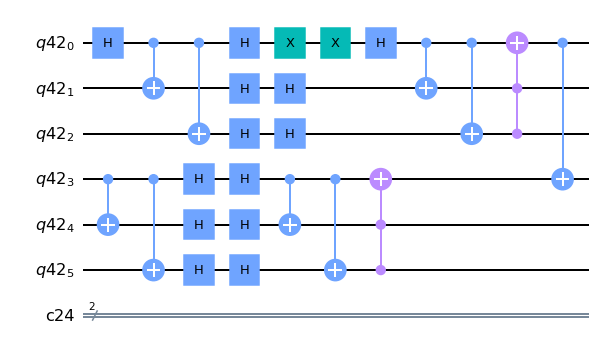

In [31]:
# For each qubit, 2 extra ancilliary qubits are used, hence totally 6 qubits are required
# let us suppose that we want to transmit q[0] and q[3], hence q[0] and q[3] are main qubits
# And q[1] and q[2] are ancilliary qubits for q[0]
# And q[4] and q[5] are ancilliary qubits for q[3]
q= QuantumRegister(6)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)

qc.h(q[0])

# Encoding the qubits so that they both bitflip and signflip code can be applied while correction
main_qubits = [0,3]
for i in main_qubits:
    qc.cx(q[i], q[i+1])
    qc.cx(q[i], q[i+2])
    qc.h(q[i])
    qc.h(q[i+1])
    qc.h(q[i+2])
    
#  Let the error gates act
for i in main_qubits:
        if chance(0.4):
            if randrange(2) == 0:
                qc.x(q[0])
                print('X Error gate acts on main qubit - {}'.format(i))
            else:
                qc.z(q[0])
                print('Z Error gate acts on main qubit - {}'.format(i))


    
# Applying the error correction
for i in main_qubits:
    qc.h(q[i])
    qc.h(q[i+1])
    qc.h(q[i+2])
    qc.cx(q[i], q[i+1])
    qc.cx(q[i], q[i+2])
    qc.ccx(q[i+2], q[i+1], q[i])


qc.cx(q[0], q[3])

qc.draw(output='mpl')

In [32]:
# Verifying by measuing
# The output has to be |00> + |11> / root(2) as the correction has been applied
qc.measure([0,3],c)

job = execute(qc,Aer.get_backend('qasm_simulator'),shots=1000)
counts = job.result().get_counts(qc)
print(counts)

{'00': 487, '11': 513}


In [33]:
# checking 100 times
# Each time should result in |00> + |11>/root(2)

n1 = 0 # Number of times we obtain |00> + |11>/root(2), should be 100 as error correction is applied
n2 = 0 # Number of times any other result is obtained, should be 0 
for r in range(100):
    print('{} iteration'.format(r))
    q = QuantumRegister(6)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q,c)
    qc.h(q[0])
    
    main_qubits = [0,3]
    for i in main_qubits:
        qc.cx(q[i], q[i+1])
        qc.cx(q[i], q[i+2])
        qc.h(q[i])
        qc.h(q[i+1])
        qc.h(q[i+2])
    
    # Error Gates in action
    for i in [0,1]:
        if chance(0.4):
            if randrange(2) == 0:
                qc.x(q[i])
                print('X Error gate acts on {} qubit'.format(i))
            else:
                qc.z(q[i])
                print('Z Error gate acts on {} qubit'.format(i))
    
    # Applying the error correction
    for i in main_qubits:
        qc.h(q[i])
        qc.h(q[i+1])
        qc.h(q[i+2])
        qc.cx(q[i], q[i+1])
        qc.cx(q[i], q[i+2])
        qc.ccx(q[i+2], q[i+1], q[i])
    
    qc.cx(q[0], q[1])
    qc.measure([0,3],c)
    job = execute(qc,Aer.get_backend('qasm_simulator'),shots=1000)
    counts = job.result().get_counts(qc)
    print(counts.get('00') )
    if counts.get('00') != None:
        n1 += 1
    else:
        n2 += 1

print('Number of times |00> +/- |11>/root(2) ', n1)
print('Number of times any other result ', n2)
# We see that everytime we get the expected bell state as error has been corrected

0 iteration
Z Error gate acts on 0 qubit
474
1 iteration
513
2 iteration
X Error gate acts on 1 qubit
510
3 iteration
494
4 iteration
Z Error gate acts on 0 qubit
Z Error gate acts on 1 qubit
480
5 iteration
X Error gate acts on 0 qubit
Z Error gate acts on 1 qubit
487
6 iteration
502
7 iteration
498
8 iteration
Z Error gate acts on 1 qubit
504
9 iteration
X Error gate acts on 1 qubit
489
10 iteration
Z Error gate acts on 1 qubit
508
11 iteration
517
12 iteration
478
13 iteration
516
14 iteration
Z Error gate acts on 0 qubit
494
15 iteration
X Error gate acts on 1 qubit
502
16 iteration
Z Error gate acts on 0 qubit
519
17 iteration
498
18 iteration
Z Error gate acts on 1 qubit
490
19 iteration
516
20 iteration
Z Error gate acts on 1 qubit
503
21 iteration
X Error gate acts on 1 qubit
509
22 iteration
X Error gate acts on 1 qubit
498
23 iteration
Z Error gate acts on 1 qubit
498
24 iteration
X Error gate acts on 0 qubit
459
25 iteration
X Error gate acts on 0 qubit
Z Error gate acts on 

**Extending Task 2.3 by applying error gates for ancillary qubits too**

Z Error gate acts on 3 main qubit
X Error gate acts on 5 main qubit


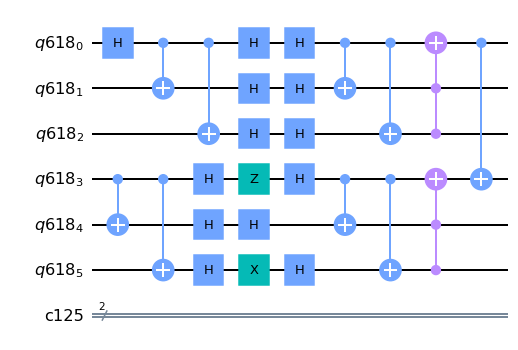

In [34]:
q= QuantumRegister(6)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)

qc.h(q[0])

# Before error gate acts(transmission occurs) lets encode the qubits
main_qubits = [0,3]
for i in main_qubits:
    qc.cx(q[i], q[i+1])
    qc.cx(q[i], q[i+2])
    qc.h(q[i])
    qc.h(q[i+1])
    qc.h(q[i+2])

# Let the error gates act
for i in range(6):
    if chance(0.4):
        if randrange(2) == 0:
            qc.x(q[i])
            print('X Error gate acts on {} main qubit'.format(i))
        else:
            qc.z(q[i])
            print('Z Error gate acts on {} main qubit'.format(i))

    
# Applying the error correction
main_qubits_indices = [0,3]
for i in main_qubits:
    qc.h(q[i])
    qc.h(q[i+1])
    qc.h(q[i+2])
    qc.cx(q[i], q[i+1])
    qc.cx(q[i], q[i+2])
    qc.ccx(q[i+2], q[i+1], q[i])


qc.cx(q[0], q[3])

qc.draw(output='mpl')

In [35]:
# Cases explained here http://bit.ly/3qqPl2A
qc.measure([0,3],c)

job = execute(qc,Aer.get_backend('qasm_simulator'),shots=1000)
counts = job.result().get_counts(qc)
print(counts)

{'00': 489, '11': 511}


In [39]:
n1 = 0 # number of times we get |00> +/- |11>/root(2), should be around 896 times out of 1000
n2 = 0 # number of times we get |01> +/- |10>/root(2), should be around 104 times out of 1000

for r in range(1000):
    print('Iteration {}'.format(r))
    q= QuantumRegister(6)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q,c)
    
    qc.h(q[0])
    
    main_qubits = [0,3]
    for i in main_qubits:
        qc.cx(q[i], q[i+1])
        qc.cx(q[i], q[i+2])
        qc.h(q[i])
        qc.h(q[i+1])
        qc.h(q[i+2])

    for i in range(6):
        if chance(0.4):
            if randrange(2) == 0:
                qc.x(q[i])
                print('X Error gate acts on {} main qubit'.format(i))
            else:
                qc.z(q[i])
                print('Z Error gate acts on {} main qubit'.format(i))
    
    main_qubits_indices = [0,3]
    for i in main_qubits:
        qc.h(q[i])
        qc.h(q[i+1])
        qc.h(q[i+2])
        qc.cx(q[i], q[i+1])
        qc.cx(q[i], q[i+2])
        qc.ccx(q[i+2], q[i+1], q[i])

    qc.cx(q[0], q[3])
    
    qc.measure([0,3],c)
    job = execute(qc,Aer.get_backend('qasm_simulator'),shots=1000)
    counts = job.result().get_counts(qc)
    if counts.get('00') != None:
        n1 += 1
    else:
        n2 += 1
    
print('number of times we get |00> +/- |11>/root(2)', n1)
print('number of times we get |01> +/- |10>/root(2)', n2)


Iteration 0
X Error gate acts on 0 main qubit
X Error gate acts on 5 main qubit
Iteration 1
X Error gate acts on 1 main qubit
Iteration 2
Z Error gate acts on 0 main qubit
X Error gate acts on 1 main qubit
Z Error gate acts on 2 main qubit
X Error gate acts on 3 main qubit
Iteration 3
Z Error gate acts on 1 main qubit
Z Error gate acts on 2 main qubit
Z Error gate acts on 3 main qubit
Iteration 4
Z Error gate acts on 0 main qubit
X Error gate acts on 1 main qubit
X Error gate acts on 4 main qubit
Iteration 5
Z Error gate acts on 0 main qubit
X Error gate acts on 2 main qubit
Z Error gate acts on 3 main qubit
Iteration 6
X Error gate acts on 0 main qubit
X Error gate acts on 4 main qubit
Iteration 7
X Error gate acts on 0 main qubit
Z Error gate acts on 3 main qubit
Z Error gate acts on 4 main qubit
Z Error gate acts on 5 main qubit
Iteration 8
X Error gate acts on 3 main qubit
Z Error gate acts on 5 main qubit
Iteration 9
Z Error gate acts on 1 main qubit
X Error gate acts on 4 main qu

Iteration 86
Z Error gate acts on 2 main qubit
Iteration 87
X Error gate acts on 4 main qubit
Iteration 88
Z Error gate acts on 1 main qubit
Z Error gate acts on 3 main qubit
X Error gate acts on 4 main qubit
Z Error gate acts on 5 main qubit
Iteration 89
Z Error gate acts on 0 main qubit
X Error gate acts on 3 main qubit
Iteration 90
X Error gate acts on 0 main qubit
X Error gate acts on 1 main qubit
X Error gate acts on 4 main qubit
X Error gate acts on 5 main qubit
Iteration 91
Z Error gate acts on 1 main qubit
X Error gate acts on 2 main qubit
Z Error gate acts on 3 main qubit
X Error gate acts on 5 main qubit
Iteration 92
Z Error gate acts on 3 main qubit
Iteration 93
X Error gate acts on 2 main qubit
X Error gate acts on 3 main qubit
Iteration 94
Z Error gate acts on 1 main qubit
Z Error gate acts on 2 main qubit
X Error gate acts on 3 main qubit
Iteration 95
Z Error gate acts on 0 main qubit
Z Error gate acts on 1 main qubit
X Error gate acts on 3 main qubit
Iteration 96
X Error

Iteration 171
Z Error gate acts on 0 main qubit
X Error gate acts on 1 main qubit
X Error gate acts on 2 main qubit
Z Error gate acts on 5 main qubit
Iteration 172
X Error gate acts on 2 main qubit
Z Error gate acts on 3 main qubit
Iteration 173
Z Error gate acts on 0 main qubit
Z Error gate acts on 2 main qubit
X Error gate acts on 5 main qubit
Iteration 174
Z Error gate acts on 0 main qubit
Z Error gate acts on 3 main qubit
Z Error gate acts on 4 main qubit
Iteration 175
Z Error gate acts on 0 main qubit
Z Error gate acts on 1 main qubit
Iteration 176
X Error gate acts on 0 main qubit
X Error gate acts on 3 main qubit
Iteration 177
X Error gate acts on 0 main qubit
Z Error gate acts on 1 main qubit
Z Error gate acts on 5 main qubit
Iteration 178
X Error gate acts on 2 main qubit
Z Error gate acts on 3 main qubit
X Error gate acts on 4 main qubit
Iteration 179
Z Error gate acts on 1 main qubit
X Error gate acts on 2 main qubit
X Error gate acts on 4 main qubit
X Error gate acts on 5 m

Iteration 262
Z Error gate acts on 2 main qubit
Iteration 263
X Error gate acts on 2 main qubit
X Error gate acts on 3 main qubit
X Error gate acts on 4 main qubit
Iteration 264
X Error gate acts on 1 main qubit
X Error gate acts on 4 main qubit
Iteration 265
X Error gate acts on 1 main qubit
Z Error gate acts on 2 main qubit
Z Error gate acts on 4 main qubit
X Error gate acts on 5 main qubit
Iteration 266
Z Error gate acts on 3 main qubit
Iteration 267
Z Error gate acts on 0 main qubit
Z Error gate acts on 1 main qubit
Z Error gate acts on 2 main qubit
X Error gate acts on 4 main qubit
Iteration 268
X Error gate acts on 0 main qubit
X Error gate acts on 3 main qubit
Z Error gate acts on 5 main qubit
Iteration 269
Iteration 270
X Error gate acts on 2 main qubit
X Error gate acts on 5 main qubit
Iteration 271
Z Error gate acts on 0 main qubit
Z Error gate acts on 1 main qubit
Z Error gate acts on 2 main qubit
X Error gate acts on 3 main qubit
X Error gate acts on 5 main qubit
Iteration 

Iteration 362
X Error gate acts on 0 main qubit
X Error gate acts on 1 main qubit
Z Error gate acts on 5 main qubit
Iteration 363
X Error gate acts on 3 main qubit
Iteration 364
X Error gate acts on 0 main qubit
Iteration 365
Z Error gate acts on 3 main qubit
Z Error gate acts on 4 main qubit
X Error gate acts on 5 main qubit
Iteration 366
Z Error gate acts on 2 main qubit
X Error gate acts on 3 main qubit
X Error gate acts on 5 main qubit
Iteration 367
X Error gate acts on 4 main qubit
Z Error gate acts on 5 main qubit
Iteration 368
X Error gate acts on 0 main qubit
Z Error gate acts on 1 main qubit
X Error gate acts on 2 main qubit
Z Error gate acts on 3 main qubit
Iteration 369
Z Error gate acts on 0 main qubit
X Error gate acts on 1 main qubit
Z Error gate acts on 2 main qubit
X Error gate acts on 3 main qubit
Z Error gate acts on 4 main qubit
Iteration 370
Z Error gate acts on 1 main qubit
X Error gate acts on 3 main qubit
X Error gate acts on 5 main qubit
Iteration 371
Z Error ga

Iteration 463
X Error gate acts on 1 main qubit
Z Error gate acts on 3 main qubit
X Error gate acts on 5 main qubit
Iteration 464
Z Error gate acts on 1 main qubit
Z Error gate acts on 2 main qubit
Z Error gate acts on 3 main qubit
Z Error gate acts on 4 main qubit
X Error gate acts on 5 main qubit
Iteration 465
Z Error gate acts on 2 main qubit
Z Error gate acts on 3 main qubit
X Error gate acts on 5 main qubit
Iteration 466
Z Error gate acts on 2 main qubit
X Error gate acts on 4 main qubit
Z Error gate acts on 5 main qubit
Iteration 467
Z Error gate acts on 0 main qubit
Z Error gate acts on 3 main qubit
Iteration 468
Z Error gate acts on 0 main qubit
Z Error gate acts on 1 main qubit
X Error gate acts on 2 main qubit
X Error gate acts on 3 main qubit
Z Error gate acts on 4 main qubit
Z Error gate acts on 5 main qubit
Iteration 469
X Error gate acts on 0 main qubit
X Error gate acts on 2 main qubit
X Error gate acts on 4 main qubit
X Error gate acts on 5 main qubit
Iteration 470
Z Er

Iteration 563
X Error gate acts on 1 main qubit
Z Error gate acts on 3 main qubit
X Error gate acts on 5 main qubit
Iteration 564
X Error gate acts on 0 main qubit
X Error gate acts on 2 main qubit
X Error gate acts on 3 main qubit
Iteration 565
X Error gate acts on 0 main qubit
Z Error gate acts on 2 main qubit
Iteration 566
Z Error gate acts on 0 main qubit
X Error gate acts on 1 main qubit
Iteration 567
Z Error gate acts on 0 main qubit
Z Error gate acts on 2 main qubit
X Error gate acts on 5 main qubit
Iteration 568
X Error gate acts on 0 main qubit
X Error gate acts on 2 main qubit
Z Error gate acts on 4 main qubit
Iteration 569
Z Error gate acts on 0 main qubit
X Error gate acts on 4 main qubit
Z Error gate acts on 5 main qubit
Iteration 570
X Error gate acts on 0 main qubit
X Error gate acts on 1 main qubit
Z Error gate acts on 5 main qubit
Iteration 571
Z Error gate acts on 1 main qubit
X Error gate acts on 2 main qubit
Iteration 572
Z Error gate acts on 1 main qubit
X Error ga

Iteration 664
X Error gate acts on 0 main qubit
X Error gate acts on 3 main qubit
Iteration 665
Z Error gate acts on 0 main qubit
Z Error gate acts on 3 main qubit
Iteration 666
Z Error gate acts on 5 main qubit
Iteration 667
X Error gate acts on 1 main qubit
Z Error gate acts on 3 main qubit
Iteration 668
X Error gate acts on 1 main qubit
X Error gate acts on 3 main qubit
Z Error gate acts on 4 main qubit
Iteration 669
Z Error gate acts on 1 main qubit
Z Error gate acts on 5 main qubit
Iteration 670
X Error gate acts on 0 main qubit
Z Error gate acts on 1 main qubit
X Error gate acts on 2 main qubit
X Error gate acts on 3 main qubit
X Error gate acts on 4 main qubit
Iteration 671
X Error gate acts on 1 main qubit
X Error gate acts on 5 main qubit
Iteration 672
Z Error gate acts on 2 main qubit
Iteration 673
Z Error gate acts on 0 main qubit
X Error gate acts on 2 main qubit
Z Error gate acts on 5 main qubit
Iteration 674
Z Error gate acts on 0 main qubit
Z Error gate acts on 3 main qu

Iteration 749
Z Error gate acts on 0 main qubit
Z Error gate acts on 3 main qubit
Iteration 750
X Error gate acts on 2 main qubit
Z Error gate acts on 3 main qubit
X Error gate acts on 5 main qubit
Iteration 751
X Error gate acts on 1 main qubit
Z Error gate acts on 3 main qubit
X Error gate acts on 5 main qubit
Iteration 752
Z Error gate acts on 1 main qubit
X Error gate acts on 5 main qubit
Iteration 753
X Error gate acts on 0 main qubit
X Error gate acts on 2 main qubit
Z Error gate acts on 3 main qubit
Iteration 754
Z Error gate acts on 2 main qubit
Iteration 755
Z Error gate acts on 0 main qubit
X Error gate acts on 2 main qubit
Z Error gate acts on 5 main qubit
Iteration 756
X Error gate acts on 4 main qubit
X Error gate acts on 5 main qubit
Iteration 757
Iteration 758
Z Error gate acts on 4 main qubit
Iteration 759
Z Error gate acts on 0 main qubit
Z Error gate acts on 2 main qubit
Z Error gate acts on 4 main qubit
Z Error gate acts on 5 main qubit
Iteration 760
Z Error gate act

Iteration 844
X Error gate acts on 0 main qubit
Z Error gate acts on 2 main qubit
Iteration 845
Z Error gate acts on 2 main qubit
X Error gate acts on 3 main qubit
Iteration 846
X Error gate acts on 5 main qubit
Iteration 847
Z Error gate acts on 2 main qubit
X Error gate acts on 4 main qubit
Iteration 848
Z Error gate acts on 1 main qubit
Z Error gate acts on 3 main qubit
Z Error gate acts on 4 main qubit
Iteration 849
Z Error gate acts on 0 main qubit
Z Error gate acts on 1 main qubit
Z Error gate acts on 3 main qubit
X Error gate acts on 5 main qubit
Iteration 850
X Error gate acts on 0 main qubit
Iteration 851
Z Error gate acts on 0 main qubit
Iteration 852
X Error gate acts on 2 main qubit
X Error gate acts on 4 main qubit
Iteration 853
X Error gate acts on 0 main qubit
X Error gate acts on 3 main qubit
X Error gate acts on 4 main qubit
Iteration 854
X Error gate acts on 3 main qubit
Z Error gate acts on 5 main qubit
Iteration 855
X Error gate acts on 0 main qubit
Iteration 856
Z 

Iteration 945
X Error gate acts on 0 main qubit
X Error gate acts on 4 main qubit
Iteration 946
X Error gate acts on 1 main qubit
X Error gate acts on 4 main qubit
Z Error gate acts on 5 main qubit
Iteration 947
X Error gate acts on 0 main qubit
Z Error gate acts on 3 main qubit
Iteration 948
X Error gate acts on 0 main qubit
X Error gate acts on 2 main qubit
X Error gate acts on 4 main qubit
X Error gate acts on 5 main qubit
Iteration 949
X Error gate acts on 2 main qubit
X Error gate acts on 4 main qubit
Iteration 950
Z Error gate acts on 3 main qubit
X Error gate acts on 5 main qubit
Iteration 951
Z Error gate acts on 0 main qubit
Z Error gate acts on 1 main qubit
Z Error gate acts on 2 main qubit
X Error gate acts on 4 main qubit
Iteration 952
Z Error gate acts on 3 main qubit
Z Error gate acts on 5 main qubit
Iteration 953
X Error gate acts on 0 main qubit
X Error gate acts on 1 main qubit
X Error gate acts on 5 main qubit
Iteration 954
Z Error gate acts on 0 main qubit
X Error ga